In [29]:
import sys 
import os

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


from Matrix_methods.utils import get_frequency_domain
from Matrix_methods.Simulate import simulate_parallel, simulate_reference
from Matrix_methods.BayesianExtractor import BayesianLayeredExtractor
from Matrix_methods.AdamExtractor import LayeredExtractor



print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

PyTorch version: 2.9.0+cpu
CUDA available: False


In [30]:
def compare_material_stacks(calculated, real):
    """
    Compare two material parameter stacks with separate real/imag errors for n.
    
    Args:
        calculated (list of tuples): [(n_complex, thickness_m), ...]
        real (list of tuples): [(n_complex, thickness_m), ...]
    
    Returns:
        list of dicts with abs and % errors for n_real, n_imag, and thickness.
    """
    results = []
    for i, ((n_calc, d_calc), (n_true, d_true)) in enumerate(zip(calculated, real), start=1):
        
        # Refractive index real part errors
        n_real_abs_err = abs(n_calc.real - n_true.real)
        n_real_pct_err = (n_real_abs_err / abs(n_true.real)) * 100 if n_true.real != 0 else float('inf')
        
        # Refractive index imaginary part errors
        n_imag_abs_err = abs(n_calc.imag - n_true.imag)
        n_imag_pct_err = (n_imag_abs_err / abs(n_true.imag)) * 100 if n_true.imag != 0 else float('inf')

        # Thickness errors
        d_abs_err = abs(d_calc - d_true)
        d_pct_err = (d_abs_err / abs(d_true)) * 100 if d_true != 0 else float('inf')

        results.append({
            "layer": i,
            "n_real_abs_err": n_real_abs_err,
            "n_real_pct_err": n_real_pct_err,
            "n_imag_abs_err": n_imag_abs_err,
            "n_imag_pct_err": n_imag_pct_err,
            "d_abs_err": d_abs_err,
            "d_pct_err": d_pct_err
        })
    
    return results

| Refractive Index | Absorption Coeff | Thickness [m] |
|------------------|------------------|----------------|
|            1.470 |        -0.001500 |      2.000e-04 |
|            2.080 |        -0.008000 |      1.120e-04 |
|            1.890 |        -0.005331 |      1.000e-04 |
(Negative absorption coeff means loss in the material.)

Total Thickness: 618.0000000000001 µm


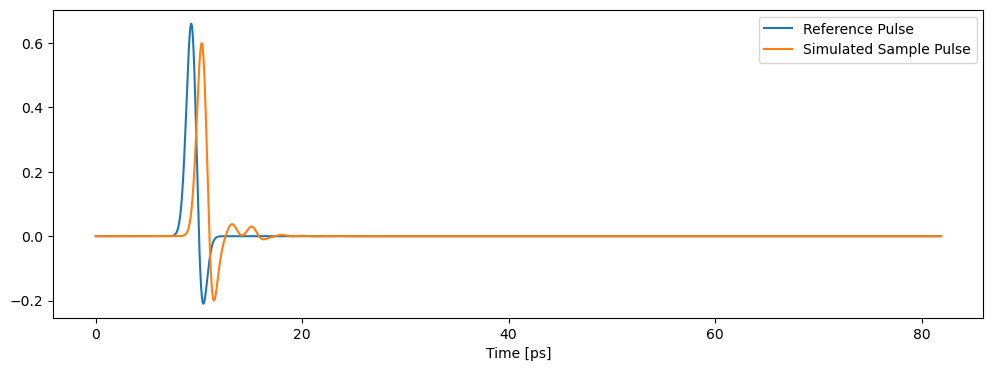

In [31]:
# Define simulation parameters
deltat = 0.02e-12  # Time step, 0,02 picoseconds
L = 2**12  # Number of time points

# Generate reference pulse
reference_pulse = simulate_reference(L, deltat)

# Define material parameters, I shall use a three layer example
# Each tuple is (complex refractive index, thickness in meters)
n_values = [1.47, 2.08, 1.89]
k_values = [-0.0015, -0.008, -0.005331]
d_values = [200e-6, 112e-6, 100e-6, 206e-6]  # Thicknesses in meters

# Experimental material parameters (ground truth)
material_params_exp = [[(n_values[i] + 1j * k_values[i]), d_values[i]] for i in range(len(n_values))]


# Simulate the experimental data
t_axis = np.arange(0, L * deltat, deltat)
T_exp, experimental_pulse = simulate_parallel(reference_pulse, material_params_exp, deltat, noise_level=0)
experimental_pulse = experimental_pulse[:L]


print("| Refractive Index | Absorption Coeff | Thickness [m] |")
print("|------------------|------------------|----------------|")

for item in material_params_exp:
    n_real = np.real(item[0])
    n_imag = np.imag(item[0])
    thickness = item[1]
    print(f"| {n_real:16.3f} | {n_imag:16.6f} | {thickness:14.3e} |")

print('(Negative absorption coeff means loss in the material.)')

print(f'\nTotal Thickness: {sum(d_values) * 1e6} µm')

plt.figure(figsize=(12,4))
#plt.title(f'Simulated Time Domain of THz Pulse Passing Through a {len(n_values)} Layered Sample')
plt.plot(t_axis*1e12, reference_pulse, label='Reference Pulse')
plt.plot(t_axis*1e12, experimental_pulse.detach().cpu().numpy(), label='Simulated Sample Pulse')
#plt.scatter(t_axis*1e12, experimental_pulse.detach().cpu().numpy(), s=2, color= 'orange', label='Simulated Sample Pulse')
plt.xlabel('Time [ps]')
plt.legend()
plt.show()

N: 4096 frequency points


C:\Users\Θόδωρας\AppData\Local\Temp\ipykernel_10868\1895586919.py:10: RuntimeWarning: divide by zero encountered in log10
  plt.plot(freqs_ref[:N//2]*1e-12, np.real(np.log10(spectrum_ref[:N//2].detach().cpu().numpy())), label='Reference Pulse')


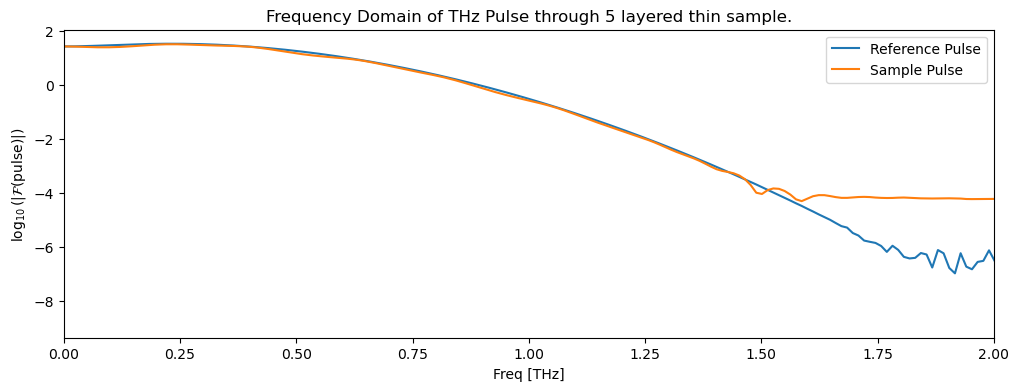

In [32]:
# Convert to frequency
freqs_ref, spectrum_ref = get_frequency_domain(reference_pulse, deltat=deltat)
freqs_sample, spectrum_sample = get_frequency_domain(experimental_pulse, deltat=deltat)

N = len(freqs_ref)
print(f'N: {N} frequency points')

plt.figure(figsize=(12,4))
plt.title('Frequency Domain of THz Pulse through 5 layered thin sample.')
plt.plot(freqs_ref[:N//2]*1e-12, np.real(np.log10(spectrum_ref[:N//2].detach().cpu().numpy())), label='Reference Pulse')
plt.plot(freqs_sample[:N//2]*1e-12, np.real(np.log10(spectrum_sample[:N//2].detach().cpu().numpy())), label='Sample Pulse')
plt.ylabel(r'$\log_{10}(|\mathcal{F}(\mathrm{pulse})|)$')
plt.xlabel('Freq [THz]')
plt.xlim(0, 2)  
plt.legend()
plt.show()

In [33]:
## Experimental params:

"""
| Refractive Index | Absorption Coeff | Thickness [m] |
|------------------|------------------|----------------|
|            1.470 |        -0.001500 |      2.000e-04 |
|            2.080 |        -0.008000 |      1.120e-04 |
|            1.890 |        -0.005331 |      1.000e-04 |
"""


optimization_bounds = [0.3, 0.015, 5e-6]

n_inits = [1.5, 2.100, 1.9]
k_inits = [0.001, 0.010, 0.007]
d_inits = [180e-06, 110e-6, 95e-6]  #Here I shall use different thickness values to test the limit of extraction
# d real: [200e-06, 112e-6, 100e-6]

layers_init = [[(n_inits[i] + 1j * k_inits[i]), d_inits[i]] for i in range(len(n_inits))]

# Optimize with fixed thickness
optimization_mask = [
    (True, True, True),
    (True, True, True),
    (True, True, True)]


initial_pulse = simulate_parallel(reference_pulse, layers_init, deltat)[1].detach().cpu().numpy()[:L]

Bayesian_optimizer = BayesianLayeredExtractor(reference_pulse, experimental_pulse, deltat, layers_init, optimize_mask=optimization_mask, optimization_bounds=optimization_bounds)
Bayesian_inits = Bayesian_optimizer.bayesian_optimization(n_calls=60)

Bayesian_pulse = simulate_parallel(reference_pulse, Bayesian_inits, deltat, noise_level=0)[1].detach().cpu().numpy()[:L]

print(Bayesian_inits)
print(material_params_exp)

Starting Bayesian Optimization with masks...
Search Boundaries for Optimized Parameters:
Layer 1 - n ∈ (1.2, 1.8)
Layer 1 - k ∈ (-0.013999999999999999, 0.016)
Layer 1 - D ∈ (0.000175, 0.00018500000000000002)
Layer 2 - n ∈ (1.8, 2.4)
Layer 2 - k ∈ (-0.004999999999999999, 0.025)
Layer 2 - D ∈ (0.000105, 0.000115)
Layer 3 - n ∈ (1.5999999999999999, 2.1999999999999997)
Layer 3 - k ∈ (-0.008, 0.022)
Layer 3 - D ∈ (9e-05, 0.0001)
[((1.3827552247790458+0.007667030711122198j), 0.00017587522515611067), ((2.129669553552447+0.012524968501044497j), 0.00011452309665864108), ((2.1569212285097974-0.004728422364698382j), 9.484322494833595e-05)]
[[(1.47-0.0015j), 0.0002], [(2.08-0.008j), 0.000112], [(1.89-0.005331j), 0.0001]]


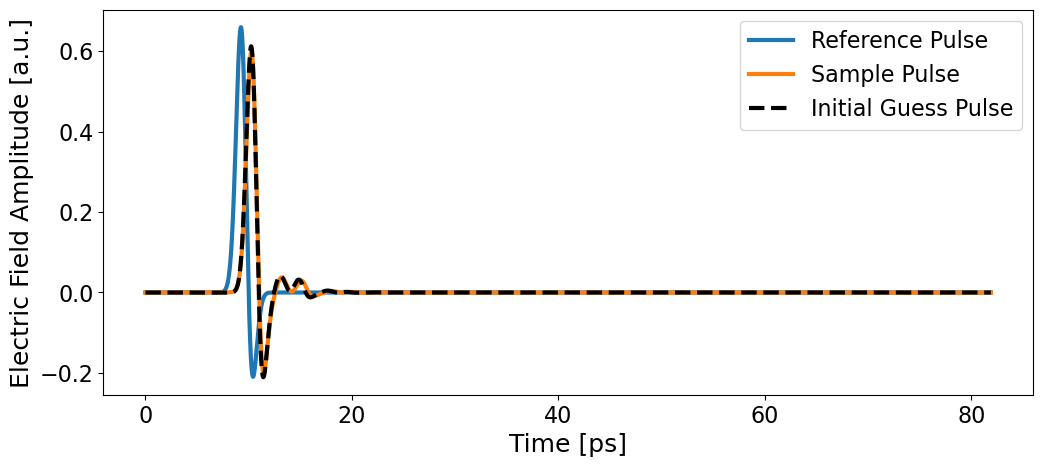

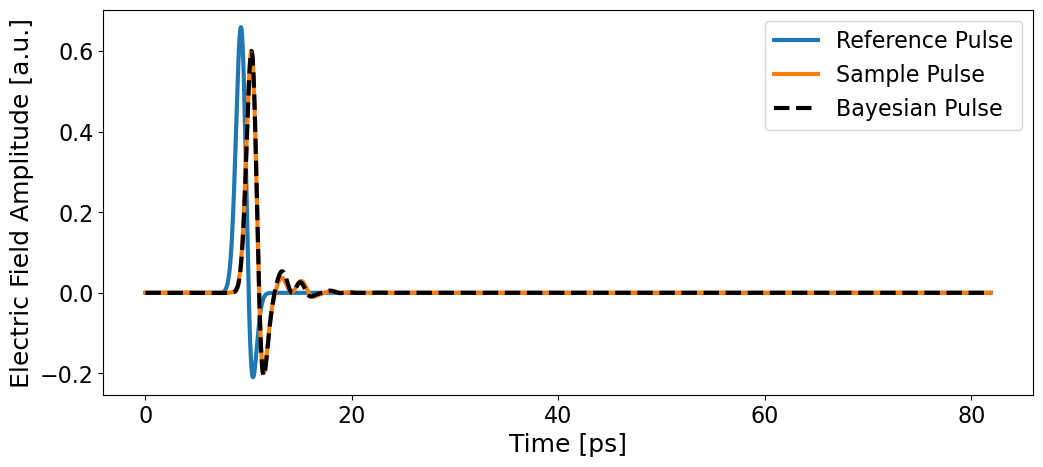

In [34]:
plt.figure(figsize=(12,5))
plt.plot(t_axis*1e12, reference_pulse, label='Reference Pulse', linewidth='3')
plt.plot(t_axis*1e12, experimental_pulse.detach().cpu().numpy(), label='Sample Pulse', linewidth='3')
plt.plot(t_axis*1e12, initial_pulse, label='Initial Guess Pulse', color='k', linestyle='--', linewidth='3')
plt.xlabel('Time [ps]', fontsize=18)
plt.ylabel('Electric Field Amplitude [a.u.]', fontsize=18)
plt.xticks(fontsize=16)  # Increase x-axis tick labels font size
plt.yticks(fontsize=16)  # Increase y-axis tick labels font size
plt.legend(fontsize=16)
plt.show()

plt.figure(figsize=(12,5))
plt.plot(t_axis*1e12, reference_pulse, label='Reference Pulse', linewidth='3')
plt.plot(t_axis*1e12, experimental_pulse.detach().cpu().numpy(), label='Sample Pulse', linewidth='3')
plt.plot(t_axis*1e12, Bayesian_pulse, label='Bayesian Pulse', color='k', linestyle='--', linewidth='3')
plt.xlabel('Time [ps]', fontsize=18)
plt.ylabel('Electric Field Amplitude [a.u.]', fontsize=18)
plt.xticks(fontsize=16)  # Increase x-axis tick labels font size
plt.yticks(fontsize=16)  # Increase y-axis tick labels font size
plt.legend(fontsize=16)
plt.show()

Fine-tuning 9 parameters for 2500 iterations.
Iteration 199, Loss: 3.366947e-04, Layer 0: n=1.4339, k=0.01322, D=194.26 µm | Layer 1: n=2.0143, k=-0.00441, D=117.69 µm | Layer 2: n=2.0172, k=-0.02663, D=98.28 µm
Iteration 399, Loss: 9.552247e-05, Layer 0: n=1.4684, k=-0.00338, D=191.60 µm | Layer 1: n=2.0368, k=0.00281, D=120.25 µm | Layer 2: n=1.9146, k=-0.01455, D=97.85 µm
Iteration 599, Loss: 3.424030e-05, Layer 0: n=1.4628, k=-0.00212, D=197.37 µm | Layer 1: n=2.0580, k=-0.00919, D=118.51 µm | Layer 2: n=1.9082, k=-0.00205, D=96.05 µm
Iteration 799, Loss: 2.388470e-05, Layer 0: n=1.4604, k=-0.00133, D=198.99 µm | Layer 1: n=2.0634, k=-0.01308, D=117.82 µm | Layer 2: n=1.9091, k=0.00130, D=95.74 µm
Iteration 999, Loss: 2.150134e-05, Layer 0: n=1.4599, k=-0.00115, D=199.46 µm | Layer 1: n=2.0652, k=-0.01415, D=117.48 µm | Layer 2: n=1.9090, k=0.00206, D=95.77 µm
Iteration 1199, Loss: 2.065639e-05, Layer 0: n=1.4600, k=-0.00109, D=199.61 µm | Layer 1: n=2.0661, k=-0.01431, D=117.24 µm

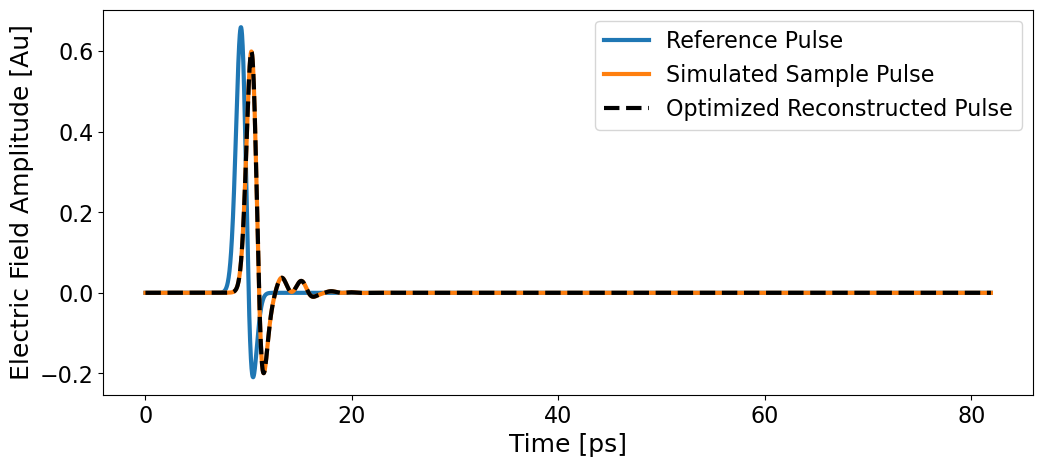

In [35]:
LE = LayeredExtractor(reference_pulse, experimental_pulse, deltat, Bayesian_inits, lr=0.001, optimize_mask=optimization_mask)
optim_params = LE.optimize(num_iterations=2500, updates=200 , alpha=1)



_, optimal_pulse = simulate_parallel(reference_pulse, optim_params, deltat, noise_level=0)
optimal_pulse = optimal_pulse[:L]

print(optim_params)
plt.figure(figsize=(12,5))
plt.plot(t_axis*1e12, reference_pulse, label='Reference Pulse', linewidth='3')
plt.plot(t_axis*1e12, experimental_pulse.detach().cpu().numpy(), label='Simulated Sample Pulse', linewidth='3')
plt.plot(t_axis*1e12, optimal_pulse.detach().cpu().numpy(), label='Optimized Reconstructed Pulse', color='k', linestyle='--', linewidth='3')
plt.xlabel('Time [ps]', fontsize=18)
plt.ylabel('Electric Field Amplitude [Au]', fontsize=18)
plt.xticks(fontsize=16)  # Increase x-axis tick labels font size
plt.yticks(fontsize=16)  # Increase y-axis tick labels font size
plt.legend(fontsize=16)
plt.show()

In [39]:
print("The final parameters given by the extraction are:")
print(optim_params)

The final parameters given by the extraction are:
[((1.4619373083114624-0.0011622484307736158j), 0.0001997457875404507), ((2.0690908432006836-0.013254444114863873j), 0.00011601639562286437), ((1.9048689603805542+0.0008418613579124212j), 9.685271652415395e-05)]


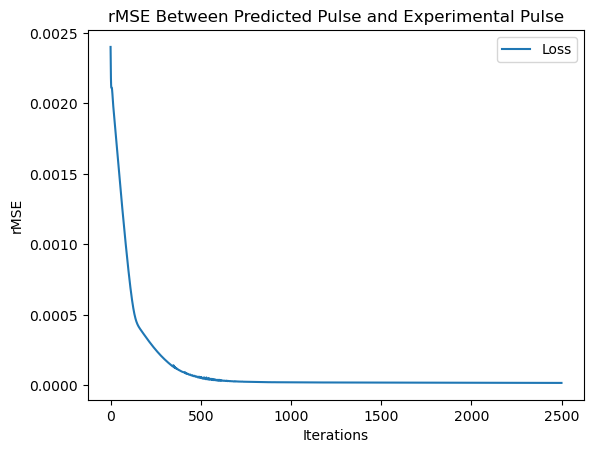

In [36]:
plt.plot(LE.loss_history, label='Loss')
plt.xlabel("Iterations")
plt.ylabel("rMSE")
plt.title("rMSE Between Predicted Pulse and Experimental Pulse")
plt.legend()
plt.show()

In [37]:
adam_errors = compare_material_stacks(optim_params, material_params_exp)
for e in adam_errors:
    print(f"Layer {e['layer']}: "
        f"n_real_abs_err={e['n_real_abs_err']:.6g} ({e['n_real_pct_err']:.2f}%), "
        f"n_imag_abs_err={e['n_imag_abs_err']:.6g} ({e['n_imag_pct_err']:.2f}%), "
        f"d_abs_err={e['d_abs_err']:.6g} ({e['d_pct_err']:.2f}%)")

Layer 1: n_real_abs_err=0.00806269 (0.55%), n_imag_abs_err=0.000337752 (22.52%), d_abs_err=2.54212e-07 (0.13%)
Layer 2: n_real_abs_err=0.0109092 (0.52%), n_imag_abs_err=0.00525444 (65.68%), d_abs_err=4.0164e-06 (3.59%)
Layer 3: n_real_abs_err=0.014869 (0.79%), n_imag_abs_err=0.00617286 (115.79%), d_abs_err=3.14728e-06 (3.15%)


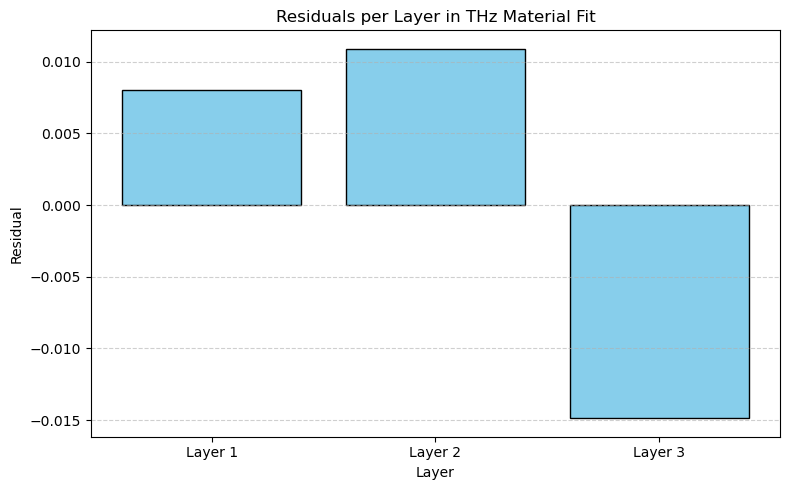

In [38]:
residuals = [material_params_exp[i][0] - optim_params[i][0] for i in range(len(material_params_exp))]
n_percentage_errors = [(np.real(residuals[i])/np.real(material_params_exp[i][0])) * 100 for i in range(len(residuals))]
k_percentage_errors = [(np.imag(residuals[i])/np.imag(material_params_exp[i][0])) * 100 for i in range(len(residuals))]

# Create bar plot
plt.figure(figsize=(8, 5))
layer_indices = [f"Layer {i+1}" for i in range(len(residuals))]

plt.bar(layer_indices, np.real(residuals), color='skyblue', edgecolor='black')
plt.title("Residuals per Layer in THz Material Fit")
plt.xlabel("Layer")
plt.ylabel("Residual")
plt.grid(axis='y', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()